# Model comparison

This notebook is intended to run a model comparison on arbitrary data of the firing rate distribution obtained from the selfconsistent model (dark matter paper) vs lognormal (or other) firing rate distributions

## Steps required

- [ ] Preparation of data
- [ ] Bayesian Inference (selfconcistent)
- [ ] Bayesian Inference (log-normal)
- [ ] compare models (KL-divergence?)
- [ ] plotting

# Comparing different models theoretically

In [8]:
import sys
import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

root_dir = Path.cwd().parent
if not root_dir in sys.path:
    sys.path.insert(0, str(root_dir))

from inference.utils.utils import p_nu

# from empirical.readData import *

In [9]:
from DM_theory.functions import (
    get_q,
    get_nu_bar,
    get_alpha_0,
    get_tau_I,
)  # , get_nu_max


def get_nu_max(tau_I, tau_M):
    return 1 / (2 * np.pi * np.sqrt(tau_I * tau_M))


def get_gamma_from_moments(nu_mean, nu_std, tau_I, tau_M, alpha_0, J):
    """
          this should only have tau_I or alpha_0 as free variables, not both
          the other one should be calculated from given data:
    nu_bar, nu_std and tau_I/alpha_0 are provided, and distribution is fully determined by 3 variables! more than that overspecifies the distribution and results in non-coherent results!
    but is it possible to specify these without approximation similar to selfcon-equations? why would it? why wouldn't it?
    """
    tau_q = 2 * (tau_I + tau_M)
    q_0 = alpha_0**2 / J**2
    q = nu_mean**2 + nu_std**2  # - q_0
    print(f"{q_0=}, {q=}")

    return np.sqrt(nu_mean / (tau_q * (q + q_0)))


def get_delta_from_moments(nu_mean, nu_std, tau_I, tau_M, alpha_0, J, which="nu"):

    # q_0 = alpha_0**2 / J**2
    q = nu_mean**2 + nu_std**2  # - q_0
    gamma = get_gamma_from_moments(nu_mean, nu_std, tau_I, tau_M, alpha_0, J)
    nu_max = get_nu_max(tau_I, tau_M)

    delta_q = np.sqrt(
        -np.log(q / nu_max**2 * np.sqrt((2 + gamma**2) / gamma**2)) * (2 + gamma**2)
    )
    delta_nu = np.sqrt(
        -np.log(nu_mean / nu_max * np.sqrt((1 + gamma**2) / gamma**2))
        * 2
        * (1 + gamma**2)
    )
    print(f"{delta_q=}, {delta_nu=}")
    if which == "q":
        return delta_q
    elif which == "nu":
        return delta_nu

q_0=4.0, q=34.0
q_0=4.0, q=34.0
delta_q=3.3470097193788213, delta_nu=3.669801003364704
gamma=1.6222142113076254, delta=3.669801003364704, nu_max=22.507907903927652
alpha_0=array([[0.04141306]])
nu_mean_=3.0000000000000004, nu_std_=3.4423222311522457
q = 20.84958234308498
nu_mean_distr=2.9993417724150992, nu_std_distr=3.4414219124485834


/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/inference/utils/utils.py:21: RuntimeWarning: divide by zero encountered in divide
  p[NU_mask] = gamma / ( nu_max * np.sqrt( -np.pi * np.log( NU_scaled ) ) ) * \


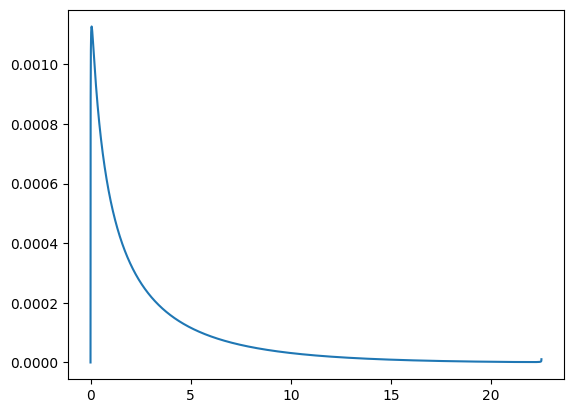

In [ ]:
nu_mean = 3.0
nu_std = 5.0
tau_I = 0.005
alpha_0 = 0.02

tau_M = 0.01
J = -1.0 * tau_M


gamma = get_gamma_from_moments(nu_mean, nu_std, tau_I, tau_M, alpha_0, J)
delta = get_delta_from_moments(nu_mean, nu_std, tau_I, tau_M, alpha_0, J, which="nu")
nu_max = get_nu_max(tau_I, tau_M)

print(f"{gamma=}, {delta=}, {nu_max=}")

alpha_0 = get_alpha_0(gamma, delta, nu_max)
print(f"{alpha_0=}")

nu_mean_ = get_nu_bar(gamma, delta, nu_max)
# nu_std_ = np.sqrt(get_q(gamma, delta, nu_max) - get_nu_bar(gamma, delta, nu_max) ** 2)
nu_std_ = np.sqrt(get_q(gamma, delta, nu_max) - nu_mean_**2)

# q = nu_mean_ ** 2 + nu_std**2
# nu_std_ = np.sqrt(q - nu_mean_ ** 2)
print(f"{nu_mean_=}, {nu_std_=}")
print("q =", get_q(gamma, delta, nu_max))


steps = 10000
x = np.linspace(0, nu_max, steps)
rho_nu = p_nu(x, {"distr": [{"gamma": gamma, "delta": delta, "nu_max": nu_max}]}) * (
    nu_max / steps
)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, rho_nu, label="p_nu")

nu_mean_distr = np.nansum((x * rho_nu)[:-1])
q_distr = np.nansum((x**2 * rho_nu)[:-1])
nu_std_distr = np.sqrt(q_distr - nu_mean_distr**2)
print(f"{nu_mean_distr=}, {nu_std_distr=}")

In [11]:
from scipy import optimize


def get_params_from_moments(nu_mean, nu_std, tau_I, tau_M):
    def delta_from_moments(gamma, nu_mean, nu_std, tau_I, tau_M, which="nu"):

        # q_0 = alpha_0**2 / J**2
        q = nu_mean**2 + nu_std**2  # - q_0
        nu_max = get_nu_max(tau_I, tau_M)

        delta_q = np.sqrt(
            -np.log(q / nu_max**2 * np.sqrt((2 + gamma**2) / gamma**2)) * (2 + gamma**2)
        )
        delta_nu = np.sqrt(
            -np.log(nu_mean / nu_max * np.sqrt((1 + gamma**2) / gamma**2))
            * 2
            * (1 + gamma**2)
        )
        # print(f"{delta_q=}, {delta_nu=}")
        if which == "q":
            return delta_q
        elif which == "nu":
            return delta_nu

    def delta_intersection(gamma, nu_mean, nu_std, tau_I, tau_M):
        return delta_from_moments(
            gamma, nu_mean, nu_std, tau_I, tau_M, which="nu"
        ) - delta_from_moments(gamma, nu_mean, nu_std, tau_I, tau_M, which="q")

    sol = optimize.root_scalar(
        delta_intersection,
        args=(nu_mean, nu_std, tau_I, tau_M),
        method="brentq",
        bracket=[0.1, 10],
    )

    nu_max = get_nu_max(tau_I, tau_M)

    gamma = sol.root
    delta = delta_from_moments(gamma, nu_mean, nu_std, tau_I, tau_M, which="nu")
    alpha_0 = get_alpha_0(gamma, delta, nu_max)
    return gamma, delta, nu_max, alpha_0


nu_mean = 1.5
nu_std = 1.0
tau_I = 0.005
tau_M = 0.01

gamma, delta, nu_max, alpha_0 = get_params_from_moments(nu_mean, nu_std, tau_I, tau_M)
print(f"{gamma=}, {delta=}, {nu_max=}, \t {alpha_0=}")

gamma=3.5539763119886203, delta=8.53208630275693, nu_max=22.507907903927652, 	 alpha_0=array([[0.0084178]])


In [12]:
# gamma = 2.1
# delta = 4.5
# nu_max = 25.0

nu_mean = get_nu_bar(gamma, delta, nu_max)
q = get_q(gamma, delta, nu_max)
nu_std = np.sqrt(q - nu_mean**2)
print(f"{nu_mean=}, {nu_std=}")

alpha_0 = get_alpha_0(gamma, delta, nu_max, p=1)
tau_I = get_tau_I(nu_max)
print(f"{q=}, {alpha_0=}, {tau_I=}")

nu_mean=1.5000000000000004, nu_std=1.0000000000000013
q=3.250000000000004, alpha_0=array([[0.0084178]]), tau_I=0.005


interactive(children=(FloatSlider(value=1.0, description='mean', max=2.0, min=0.1), FloatSlider(value=1.0, des…

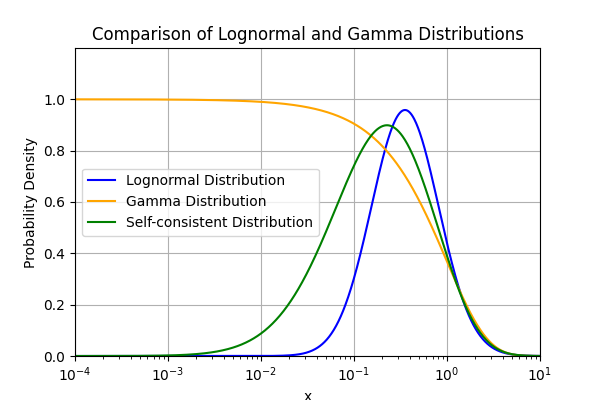

In [18]:
from scipy.stats import lognorm as fun_lognorm, gamma as fun_gamma
from DM_theory.functions import p_nu
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, HBox, VBox, Output, FloatSlider
%matplotlib ipympl

# Parameters
mean = 2
std = 1

x = np.logspace(-4, 1, 1000)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

(h_lognorm,) = ax.plot(
    x, np.full(x.shape, np.nan), label="Lognormal Distribution", color="blue"
)
(h_gamma,) = ax.plot(
    x, np.full(x.shape, np.nan), label="Gamma Distribution", color="orange"
)
(h_selfcon,) = ax.plot(
    x, np.full(x.shape, np.nan), label="Self-consistent Distribution", color="green"
)

ax.set_title("Comparison of Lognormal and Gamma Distributions")
ax.set_xscale("log")
plt.setp(ax, xlim=[10**(-4),10],xlabel="x", ylabel="Probability Density")


@interact(mean=(0.1, 2.0), std=(0.1, 5.0),tau_I=(0.001, 20))#, alpha_0=(0.0, 200))
def update_plot(mean=1.0, std=1.0, tau_I = 5):

	tau_I /= 1000.
	# alpha_0 /= 1000.

	gamma,delta,nu_max,alpha_0 = get_params_from_moments(mean, std, tau_I, tau_M)
	# gamma = get_gamma_from_moments(mean, std, tau_I, tau_M, alpha_0, J)
	# delta = get_delta_from_moments(mean, std, tau_I, tau_M, alpha_0, J)
	# nu_max = get_nu_max(tau_I, tau_M)

	print(f"{gamma=}, {delta=}, {nu_max=}")
	print(f"{alpha_0=}")
	print(get_nu_bar(gamma, delta, nu_max,))

	# Calculate parameters for lognormal distribution
	s = np.sqrt(np.log(1 + (std / mean) ** 2))  # shape parameter
	scale = mean / np.sqrt(1 + (std / mean) ** 2)  # scale parameter

	# Calculate parameters for gamma distribution
	scale_gamma = std**2 / mean
	# theta = std**2 / mean  # scale parameter
	# k = mean / theta  # shape parameter
	alpha = 1 / std**2  # shape parameter

	# Generate x values

	# Lognormal and gamma PDFs
	lognormal_pdf = fun_lognorm.pdf(x, s, scale=scale)
	gamma_pdf = fun_gamma.pdf(x, alpha, scale=scale_gamma)
	selfcon_pdf = p_nu(x, gamma, delta, nu_max)

	max_val = max(
		lognormal_pdf.max(),
		gamma_pdf.max(),
		selfcon_pdf.max(),
	)

	# Plot
	h_lognorm.set_ydata(
		lognormal_pdf
	)  # , label="Lognormal Distribution", color="blue")
	h_gamma.set_ydata(gamma_pdf)  # , label="Gamma Distribution", color="orange")
	h_selfcon.set_ydata(
		selfcon_pdf
	)  # , label="Self-consistent Distribution", color="green")
	# ax.plot(x, gamma_pdf, label="Gamma Distribution", color="orange")
	# ax.plot(x, selfcon_pdf, label="Self-consistent Distribution", color="green")
	plt.setp(ax,ylim=[0, max_val * 1.2])
	fig.canvas.draw_idle()


ax.legend()
ax.grid()
plt.show()

/tmp/ipykernel_254561/619213161.py:14: RuntimeWarning: invalid value encountered in sqrt
  delta_nu = np.sqrt(


Text(0, 0.5, '$p(\\nu)$')

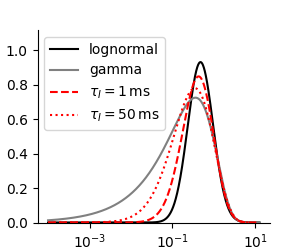

In [39]:
mean = 1.0
std = 0.8
tau_I = 0.005
tau_M = 0.01

# gamma = get_gamma_from_moments(mean, std, tau_I, tau_M, alpha_0, J)
# delta = get_delta_from_moments(mean, std, tau_I, tau_M, alpha_0, J)
# nu_max = get_nu_max(tau_I, tau_M)

# print(f"{gamma=}, {delta=}, {nu_max=}")
# print(f"{alpha_0=}")
# print(get_nu_bar(gamma, delta, nu_max,))


# Calculate parameters for lognormal distribution
s = np.sqrt(np.log(1 + (std / mean) ** 2))  # shape parameter
scale = mean / np.sqrt(1 + (std / mean) ** 2)  # scale parameter

# Calculate parameters for gamma distribution
scale_gamma = std**2 / mean
# theta = std**2 / mean  # scale parameter
# k = mean / theta  # shape parameter
alpha = 1 / std**2  # shape parameter

# Generate x values
x = np.logspace(-4, 1.1, 1001)

# Lognormal and gamma PDFs
lognormal_pdf = fun_lognorm.pdf(x, s, scale=scale)
gamma_pdf = fun_gamma.pdf(x, alpha, scale=scale_gamma)



fig = plt.figure(figsize=(3, 2.5))
ax = fig.add_subplot(111)
# Plot
ax.plot(x, lognormal_pdf,'k-',label='lognormal')  # , label="Lognormal Distribution", color="blue")
ax.plot(x, gamma_pdf,'grey',ls='-',label='gamma')  # , label="Gamma Distribution", color="orange")

gamma, delta, nu_max, alpha_0 = get_params_from_moments(mean, std, tau_I=0.001, tau_M=0.01)
selfcon_pdf = p_nu(x, gamma, delta, nu_max)
ax.plot(x, selfcon_pdf,'r--',label="$\\tau_I=1\,$ms")  # , label="Self-consistent Distribution", color="green")

gamma, delta, nu_max, alpha_0 = get_params_from_moments(mean, std, tau_I=0.050, tau_M=0.01)
selfcon_pdf = p_nu(x, gamma, delta, nu_max)
ax.plot(x, selfcon_pdf,'r:',label="$\\tau_I=50\,$ms")  # , label="Self-consistent Distribution", color="green")

max_val = max(
    lognormal_pdf.max(),
    gamma_pdf.max(),
    selfcon_pdf.max(),
)

# ax.plot(x, gamma_pdf, label="Gamma Distribution", color="orange")
# ax.plot(x, selfcon_pdf, label="Self-consistent Distribution", color="green")
plt.setp(ax, ylim=[0, max_val * 1.2])
ax.set_xscale("log")
ax.legend()

ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("$\\nu$ [Hz]")
ax.set_ylabel("$p(\\nu)$")

### Preparation of data
Data has to be brought into a consistent form, first: **Pandas dataframe**
* row=neuron-ID
* column=multicolumn
    * level 1: mouse-type
    * level 2: mouse-ID

Finally data is read into according variables

In [ ]:
import pandas as pd

# import seaborn as sns

# mP_withSilent = ModelParams('empirical',filePath='../../data/BuscheLab/2P_data.xlsx',include_silent=True)


def initialize_rate_df(mouse_types, nMice, n_layer=1, n_cluster=1):

    ## initializing an empty pandas-dataframe to store neuron firing rate data
    # mouse_types: list(str)
    #    list of mouse types
    # nMice:       list(int)
    #    number of mice per mouse type
    # n_layer:     int [default: 1]
    #    number of layers in the data
    # n_cluster:   int [default: 1]
    #    number of neuron cluster types (exc., inh., ...)

    ## creating the column labels
    col_names = []
    for mouse_type in mouse_types:
        for mouse_ID in range(max(nMice)):
            for layer in range(n_layer):
                for cluster in range(n_cluster):
                    col_names.append((mouse_type, mouse_ID, layer, cluster))

    ## creating an empty dataframe
    df = pd.DataFrame(columns=col_names)
    df.columns = pd.MultiIndex.from_tuples(
        df.columns, names=["mouse type", "mouse ID", "layer", "cluster"]
    )

    return df


df = initialize_rate_df(
    mouse_types=["WT", "LM", "cTKO"], nMice=[3, 3, 4], n_layer=1, n_cluster=1
)
# n_neuron = 1000
# ind_names = []
# for layer in range(n_layer):
#    for cluster in range(n_cluster):
#        for neuron_ID in range(n_neuron):
#            ind_names.append((layer,cluster,neuron_ID))

# df = pd.DataFrame(np.random.randn(n_neuron,len(mouse_types)*max(nMice)*n_layer*n_cluster),columns=col_names)
# df.index = pd.MultiIndex.from_tuples(df.index, names=(u'ID'))

In [13]:
df

Empty DataFrame
Columns: [(WT, 0, 0, 0), (WT, 0, 0, 1), (WT, 1, 0, 0), (WT, 1, 0, 1), (WT, 2, 0, 0), (WT, 2, 0, 1), (WT, 3, 0, 0), (WT, 3, 0, 1), (LM, 0, 0, 0), (LM, 0, 0, 1), (LM, 1, 0, 0), (LM, 1, 0, 1), (LM, 2, 0, 0), (LM, 2, 0, 1), (LM, 3, 0, 0), (LM, 3, 0, 1), (cTKO, 0, 0, 0), (cTKO, 0, 0, 1), (cTKO, 1, 0, 0), (cTKO, 1, 0, 1), (cTKO, 2, 0, 0), (cTKO, 2, 0, 1), (cTKO, 3, 0, 0), (cTKO, 3, 0, 1)]
Index: []

[0 rows x 24 columns]

In [5]:
mP_withSilent.rates_raw.shape

(13, 1, 1, 370)

In [ ]:
mP.rates_raw

df.xs("WT", level="mouse type", axis=1)
df

mouse type        WT                  LM                cTKO          
mouse ID           0         1         0         1         0         1
layer              0         0         0         0         0         0
cluster            0         0         0         0         0         0
0          -0.821566  0.372431 -0.992036  0.107506  0.786820  0.272716
1          -0.035196 -1.127935  0.787413 -0.166839  0.306910 -0.706743
2           1.877915 -0.339093 -1.641550  0.062607  1.038418  0.356631
3          -1.057294  0.200217  0.005318 -0.829674  0.290564 -0.494596
4          -0.646761 -2.154097 -0.704697  0.975074  0.601389  2.032919
..               ...       ...       ...       ...       ...       ...
995        -0.772357 -0.452172 -1.528291 -1.367829 -1.134900 -0.922199
996         0.698880  0.455069 -0.584202  1.347918  0.932154 -0.793963
997         0.352662  1.549799  0.431776 -0.489599  0.157914  1.391942
998        -0.819327  0.442166 -0.757770 -0.507246 -0.321333 -2.108448
999         0.994412  0.351766 -1.407336  1.021817  0.236158  2.390859

[1000 rows x 6 columns]

In [9]:
mP_withSilent.spikes_raw.shape

(13, 1, 1, 370)

### Bayesian Inference (selfconsistent)
Running inference (pymc3, H(amiltonian)MC) on data, inferring best parameters

### Bayesian Inference (log-normal)
Running inference (pymc3, H(amiltonian)MC) on data, inferring best parameters